In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from plotly import express as px
from plotly import graph_objects as go
import warnings

sns.set(style="whitegrid")

warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_excel("Cleaned_Black_Money_Dataset_2013.xlsx")

df.head()


,Transaction ID,Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country
0,TX0000004137,India,2.049673e+06,Stocks Transfer,2013-06-22 08:00:00,Person_518,Finance,Brazil,False,Illegal,6,8,Bank_81,Switzerland
1,TX0000006706,China,4.988322e+05,Property Purchase,2013-10-07 09:00:00,Person_6889,Luxury Goods,Russia,False,Illegal,8,8,Bank_194,Luxembourg
2,TX0000003539,Singapore,1.612514e+06,Offshore Transfer,2013-05-28 10:00:00,Person_820,Luxury Goods,South Africa,False,Illegal,7,7,Bank_207,Cayman Islands
3,TX0000006584,Singapore,3.458205e+06,Cash Withdrawal,2013-10-02 07:00:00,Person_7370,Luxury Goods,UAE,False,Legal,10,2,Bank_444,Bahamas
4,TX0000001994,UAE,1.136456e+05,Stocks Transfer,2013-03-25 01:00:00,Person_9308,Luxury Goods,China,False,Illegal,3,1,Bank_116,Panama


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Columns that need encoding
categorical_columns = ['Country', 'Transaction Type', 'Industry', 'Destination Country', 'Source of Money', 'Tax Haven Country']

# Check for columns that are not of type 'object' and convert them if needed
for col in categorical_columns:
    if df[col].dtype != 'object':
        df[col] = df[col].astype(str)  # Convert to string for consistent encoding

# Encode categorical features using LabelEncoder as an alternative to pd.get_dummies()
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
# Feature Engineering: Add Month and Year of the Transaction
df['Transaction Month'] = df['Date of Transaction'].dt.month
df['Transaction Year'] = df['Date of Transaction'].dt.year

df.to_excel('Cleaned_Black_Money_Dataset_2013.xlsx')

df.head(5)

,Transaction ID,Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country,Transaction Month,Transaction Year
0,TX0000004137,2,2.049673e+06,4,2013-06-22 08:00:00,Person_518,3,0,False,0,6,8,Bank_81,5,6,2013
1,TX0000006706,1,4.988322e+05,3,2013-10-07 09:00:00,Person_6889,4,3,False,0,8,8,Bank_194,2,10,2013
2,TX0000003539,4,1.612514e+06,2,2013-05-28 10:00:00,Person_820,4,5,False,0,7,7,Bank_207,1,5,2013
3,TX0000006584,4,3.458205e+06,0,2013-10-02 07:00:00,Person_7370,4,7,False,1,10,2,Bank_444,0,10,2013
4,TX0000001994,7,1.136456e+05,4,2013-03-25 01:00:00,Person_9308,4,1,False,0,3,1,Bank_116,3,3,2013


In [ ]:
# Group by Transaction Year (and Country, if needed) and aggregate
data_grouped = df.groupby(['Transaction Year']).agg({
    'Amount (USD)': 'sum',                      # Sum of black money amount per year
    'Money Laundering Risk Score': 'mean',      # Average risk score per year
    'Shell Companies Involved': 'mean'          # Average shell companies involved
}).reset_index()

# Display to verify the aggregated data
print(data_grouped.head())

   Transaction Year  Amount (USD)  Money Laundering Risk Score  \
0              2013  1.244472e+10                        5.568   

   Shell Companies Involved  
0                    4.4816  


In [ ]:
# Set Transaction Year as the index to create a time series format
time_series_data = data_grouped.set_index('Transaction Year')['Amount (USD)']
print(time_series_data)


Transaction Year
2013    1.244472e+10
Name: Amount (USD), dtype: float64


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Define and fit an ARIMA model (modify order if needed based on data behavior)
model = ARIMA(time_series_data, order=(1, 1, 1))
arima_result = model.fit()

# Forecast for the next 5 years
forecast = arima_result.forecast(steps=5)
print("Forecasted Amounts:", forecast)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Forecasted Amounts: 1    1.244472e+10
2    1.244472e+10
3    1.244472e+10
4    1.244472e+10
5    1.244472e+10
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


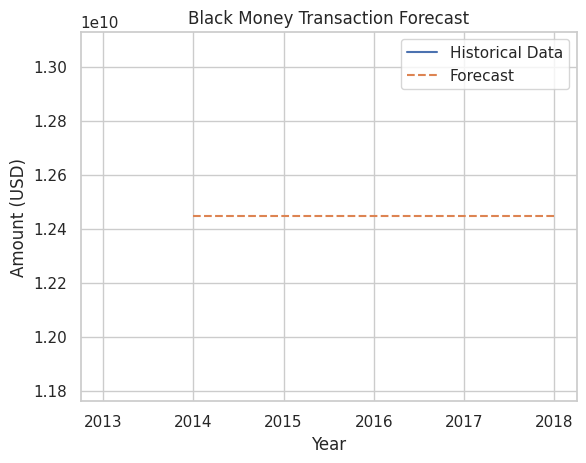

In [ ]:
import matplotlib.pyplot as plt

# Plot historical data and forecasts
plt.plot(time_series_data, label='Historical Data')
plt.plot(range(time_series_data.index[-1] + 1, time_series_data.index[-1] + 6), forecast, label='Forecast', linestyle='--')
plt.xlabel('Year')
plt.ylabel('Amount (USD)')
plt.title('Black Money Transaction Forecast')
plt.legend()
plt.show()
